# Docstrum

### Set-up

In [80]:
import cv2
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

### Pre-processing

Here I implemented a simple binarization procedure (otsu's thresholding). 

The implementation of the $k$-fill filter proposed in the paper is not yet implemented. # todo where can I find it ?

Instead, I'm just removing small connected components.

In [81]:
# def get_binary_image(img):
#     thresh = skfilters.threshold_otsu(img)
#     return img < thresh

def remove_small_components(binary_image, k):
    """
    Remove connected components smaller than a given size.

    Args:
        binary_image (numpy.ndarray): Binary image (1 for foreground, 0 for background).
        k (int): Minimum size of connected components to retain.

    Returns:
        numpy.ndarray: Binary image with small components removed.
    """
    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Create an output image initialized to 0
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    # Iterate over each component
    for i in range(1, num_labels):  # Skip the background label (0)
        if stats[i, cv2.CC_STAT_AREA] >= k:
            # Retain components larger than or equal to k
            output_image[labels == i] = 1
    
    return output_image

In [82]:
# binary_image = cv2.imread('test1.png', cv2.IMREAD_GRAYSCALE) # todo it's not a binary image but grayscale
# ret, binary_image_1 = cv2.threshold(binary_image, 180, 255, cv2.THRESH_BINARY) # todo try this other method works better with other images
# binary_image_2 = cv2.adaptiveThreshold(binary_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                      cv2.THRESH_BINARY, 9, 1)
# binary_image_average = (binary_image_1 + binary_image_2) / 2  
# # apply adaptive thresholding to the average image
# binary_image_average = binary_image_average.astype(np.uint8)
# binary_image = cv2.adaptiveThreshold(binary_image_average, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                      cv2.THRESH_BINARY, 9, 1)
# binary_image = np.array(binary_image == 0, dtype=np.uint8)
# binary_image = remove_small_components(binary_image, 15)

In [83]:
binary_image = cv2.imread('test1.png', cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(binary_image, 128, 255, cv2.THRESH_BINARY)
binary_image = (binary_image == 0).astype(np.uint8)  # Invert binary image (1 for text, 0 for background)
#binary_image = remove_small_components(binary_image, 15)

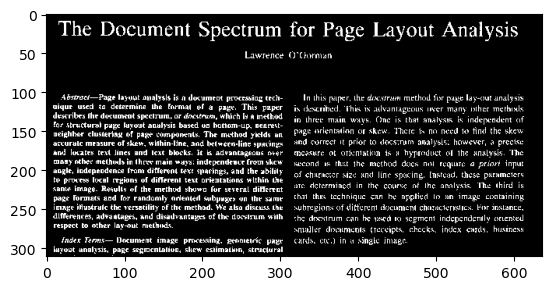

In [84]:
plt.imshow(binary_image, cmap='gray')

In [85]:
def get_binary_image_voting(image):
    """
    Apply multiple binarization methods and use voting to determine final result.
    
    Args:
        image: Input grayscale image
        
    Returns:
        Binary image where text=1, background=0
    """
    # Method 1: Simple thresholding
    _, binary1 = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    
    # Method 2: Adaptive Gaussian thresholding
    binary2 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 9, 1)
    
    # Method 3: Otsu's thresholding
    _, binary3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Method 4: Adaptive Mean thresholding
    binary4 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    
    # Method 5: Niblack's thresholding (approximated using local stats)
    kernel_size = 15
    padding = kernel_size // 2
    
    # Calculate local mean and std
    padded = cv2.copyMakeBorder(image, padding, padding, padding, padding, 
                               cv2.BORDER_REFLECT)
    local_mean = cv2.blur(padded, (kernel_size, kernel_size))
    local_std = np.zeros_like(padded, dtype=np.float32)
    cv2.blur(padded.astype(np.float32)**2, (kernel_size, kernel_size), local_std)
    local_std = np.sqrt(local_std - local_mean**2)
    
    # Crop back to original size
    local_mean = local_mean[padding:-padding, padding:-padding]
    local_std = local_std[padding:-padding, padding:-padding]
    
    # Niblack threshold: mean + k * std
    k = -0.2
    binary5 = np.zeros_like(image)
    binary5[image > local_mean + k * local_std] = 255
    
    # Convert all to binary (0/1) and invert if needed
    binaries = [
        binary1 == 0,
        binary2 == 0,
        binary3 == 0,
        binary4 == 0,
        binary5 == 0
    ]
    
    # Voting
    votes = sum(binaries)
    final_binary = votes >= 3  # Majority vote (at least 3 out of 5)
    
    return final_binary.astype(np.uint8)


def visualize_all_methods(image):
    """
    Visualize results of all binarization methods in separate plots.
    """
    # Original image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Simple threshold
    _, binary1 = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary1 == 0, cmap='gray')
    plt.title('Simple Threshold')
    plt.axis('off')
    plt.show()
    
    # Adaptive Gaussian
    binary2 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 9, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary2 == 0, cmap='gray')
    plt.title('Adaptive Gaussian')
    plt.axis('off')
    plt.show()
    
    # Otsu's method
    _, binary3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary3 == 0, cmap='gray')
    plt.title('Otsu')
    plt.axis('off')
    plt.show()
    
    # Adaptive Mean
    binary4 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary4 == 0, cmap='gray')
    plt.title('Adaptive Mean')
    plt.axis('off')
    plt.show()
    
    # Niblack
    kernel_size = 15
    padding = kernel_size // 2
    padded = cv2.copyMakeBorder(image, padding, padding, padding, padding, 
                               cv2.BORDER_REFLECT)
    local_mean = cv2.blur(padded, (kernel_size, kernel_size))
    local_std = np.zeros_like(padded, dtype=np.float32)
    cv2.blur(padded.astype(np.float32)**2, (kernel_size, kernel_size), local_std)
    local_std = np.sqrt(local_std - local_mean**2)
    local_mean = local_mean[padding:-padding, padding:-padding]
    local_std = local_std[padding:-padding, padding:-padding]
    k = -0.2
    binary5 = np.zeros_like(image)
    binary5[image > local_mean + k * local_std] = 255
    plt.figure(figsize=(10, 10))
    plt.imshow(binary5 == 0, cmap='gray')
    plt.title('Niblack')
    plt.axis('off')
    plt.show()
    
    # Voted result
    final_binary = get_binary_image_voting(image)
    plt.figure(figsize=(10, 10))
    plt.imshow(final_binary, cmap='gray')
    plt.title('Voted Result')
    plt.axis('off')
    plt.show()

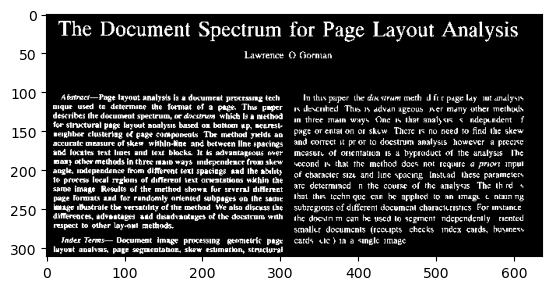

In [154]:
# Read image
image = cv2.imread('test1.png', cv2.IMREAD_GRAYSCALE)

# Get binary image using voting
# binary_image = get_binary_image_voting(image)
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
binary_image = (binary_image == 0).astype(np.uint8)
# for i in range (1, 15):
#     binary_image = remove_small_components(binary_image, i)
#     print ("k = ", i)
#     plt.imshow(binary_image, cmap='gray')
#     plt.show()

binary_image = remove_small_components(binary_image, 7)
plt.imshow(binary_image, cmap='gray')


### Extract components centroids

In [155]:
def extract_text_centroids(binary_image):
    """
    Extract centroids of connected components in a binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        
    Returns:
        list of tuples: List of (x, y) coordinates of centroids.
    """
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    
    # Exclude background (label 0)
    text_centroids = [(int(c[0]), int(c[1])) for i, c in enumerate(centroids) if i != 0]
    
    return text_centroids


def plot_text_centroids(binary_image, centroids, save = False):
    """
    Plots the text centroids on top of the binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        centroids (list of tuples): List of (x, y) coordinates of text centroids.
    """
    # Create a color image to overlay centroids
    binary_color = cv2.cvtColor(((1-binary_image) * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    # Overlay centroids
    for (x, y) in centroids:
        cv2.circle(binary_color, (x, y), radius=3, color=(255, 0, 0), thickness=-1)  # Red circles
    if save:
        cv2.imwrite("centroids.png", binary_color)
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_color)
    plt.title("Text Centroids Overlay")
    plt.axis("off")
    plt.show()

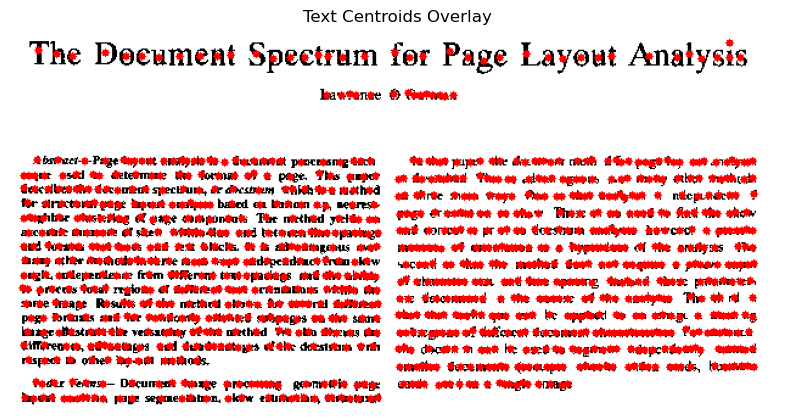

In [156]:
centroids = extract_text_centroids(binary_image)
plot_text_centroids(binary_image, centroids)

### Find $k$ nearest neighbors, their distances and their angles

Here we shall set $k=5$ as suggested by the paper (still, this is a parameter we can play with).

In [157]:
from scipy.spatial import KDTree
import math

def find_k_nearest_neighbors(centroids, k):
    """
    Find the k-nearest neighbors for each centroid and their corresponding distances and angles.

    Args:
        centroids (list of tuples): List of (x, y) coordinates of centroids.
        k (int): Number of nearest neighbors to find.

    Returns:
        neighbor_indices: A dictionary where keys are centroid indices and values are lists of the indices
          of its k-nearest neighbors.
        neighbor_distances: A dictionary where keys are centroid indices and values are lists of the distances
          to its k-nearest neighbors.
        neighbor_indices: A dictionary where keys are centroid indices and values are lists of the angles
          to its k-nearest neighbors.
    """
    if len(centroids) < k + 1:
        raise ValueError("Number of centroids must be greater than k.")
    
    # Convert centroids to numpy array
    centroids_array = np.array(centroids)
    
    # Build a KDTree for efficient nearest neighbor search
    tree = KDTree(centroids_array)
    
    # Find k+1 neighbors for each centroid (include the point itself)
    distances, indices = tree.query(centroids_array, k=k+1)  # query returns (distances, indices)
    
    # Initialize dictionaries
    neighbor_indices = {}
    neighbor_distances = {}
    neighbor_angles = {}
    
    # Extract the neighbor indices (skip the first as it's the point itself)
    for i in range(len(centroids)):
        indices_list = []
        distances_list = []
        angles_list = []
        for j in range(1, k+1):  # Skip the first one as it's the point itself
            neighbor_idx = indices[i][j]
            dist = distances[i][j]
            # Calculate angle between centroid[i] and centroid[neighbor_idx]
            x1, y1 = centroids[i]
            x2, y2 = centroids[neighbor_idx]
            if -math.pi/2 <= np.arctan2(y2 - y1, x2 - x1) and np.arctan2(y2 - y1, x2 - x1) < math.pi/2:
                angle = np.arctan2(y2 - y1, x2 - x1)
            else: 
                angle = np.arctan2(y1 - y2, x1 - x2)
            
            # Append the values to the respective lists
            indices_list.append(neighbor_idx)
            distances_list.append(dist)
            angles_list.append(np.rad2deg(angle)) # Convert to degrees
        
        # Store in dictionaries indexed by the position of the centroid
        neighbor_indices[i] = indices_list
        neighbor_distances[i] = distances_list
        neighbor_angles[i] = angles_list
    
    return neighbor_indices, neighbor_distances, neighbor_angles


def plot_neighbours(binary_image, centroids, neighbors, point):
    """
    Plots the k-nearest neighbors of point on top of the binary image.
    
    Args:
        binary_image (numpy.ndarray): Binary image of the document (1 for text, 0 for background).
        centroids (list of tuples): List of (x, y) coordinates of text centroids.
        neighbors: dict where keys are centroid indices and values are lists of the indices
          of its k-nearest neighbors.
        point: centroid index to plot its k-nearest neighbors
    """
    # Create a color image to overlay centroids
    binary_color = cv2.cvtColor((binary_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    # Overlay centroids
    for pos in neighbors[point]:
        (x, y) = centroids[pos]
        cv2.circle(binary_color, (x, y), radius=3, color=(255, 0, 0), thickness=-1)  # Red circles
    (x, y) = centroids[point]
    cv2.circle(binary_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)  # Red circle
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_color)
    plt.title("Example of a centroid and its nearest neighbors")
    plt.axis("off")
    plt.show()


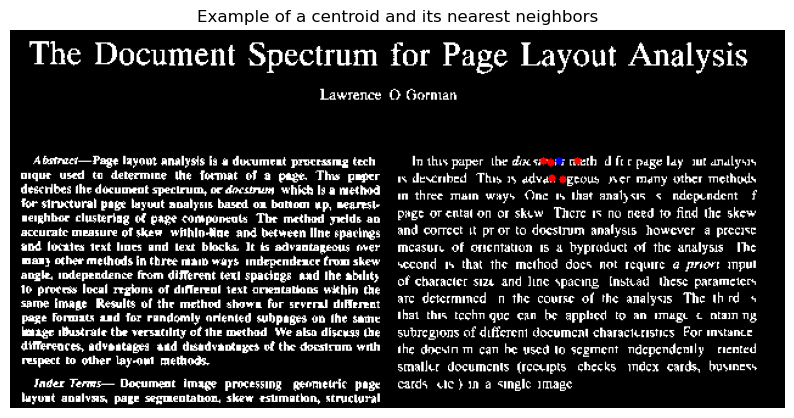

In [158]:
neighbors, distances, angles = find_k_nearest_neighbors(centroids, 5)
plot_neighbours(binary_image, centroids, neighbors, point=105)

### Build docstrum

In [159]:
def plot_docstrum(centroids, neighbor_indices):
    """
    Plot the relative position of neighbors to each centroid in the plane.
    Each centroid is translated to (0, 0), and its neighbors are plotted accordingly.

    Args:
        centroids (list of tuples): List of (x, y) coordinates of centroids.
        neighbor_indices (dict): Dictionary where keys are centroid indices, and values are lists of k nearest neighbors' indices.
    """
    
    # Initialize list to hold plot data
    plot_points = []
    
    for i in range(len(centroids)):
        centroid = centroids[i]

        # For each neighbor, translate it and store the data
        for neighbor_idx in neighbor_indices[i]:
            neighbor = centroids[neighbor_idx]
            translated_neighbor = np.array([neighbor[0] - centroid[0], neighbor[1] - centroid[1]])
            plot_points.append(translated_neighbor)
    
    # Convert plot_points and plot_lines to numpy arrays for faster plotting
    plot_points = np.array(plot_points)
    
    # Create the plot
    plt.figure(figsize=(8, 8))

    # Plot the neighbors (blue circles)
    plt.scatter(plot_points[1:, 0], plot_points[1:, 1], color='blue', marker='o')
    
    # Set axes properties
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Relative X')
    plt.ylabel('Relative Y')
    plt.title('Relative Positions of Neighbors to Each Centroid')
    plt.grid(True)
    plt.show()

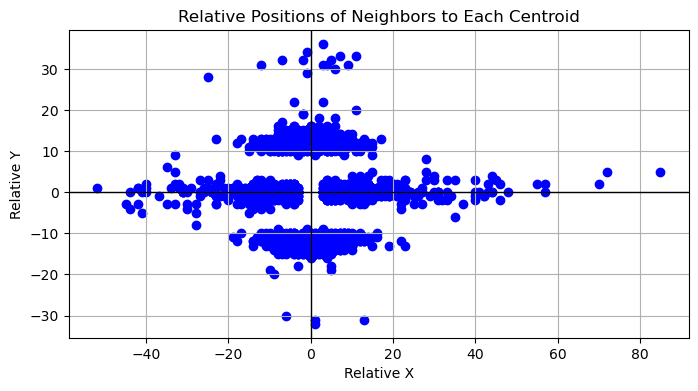

In [160]:
plot_docstrum(centroids, neighbors)

### Plot angles histogram and find main orientation

Circular smoothing of the histogram is still to be implemented.

A somehow hidden parameter is the resolution (number of bins) in the histogram (need to check).

In [161]:
def plot_angle_histogram(neighbor_angles):
    """
    Plot a histogram of the angles in the neighbor_angles dictionary.

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.
    """
    # Extract all the angles into a single list
    angles = [angle for angles_list in neighbor_angles.values() for angle in angles_list]
    
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(angles, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Neighbor Angles')
    plt.grid(True)
    plt.show()

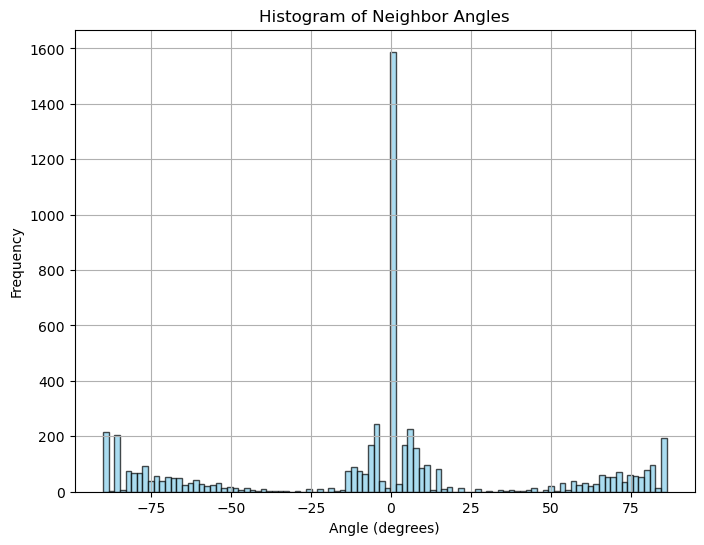

In [162]:
plot_angle_histogram(angles)

In [163]:
def find_peak_angle(neighbor_angles):
    """
    Find the peak angle in the neighbor_angles dictionary.

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.

    Returns:
        float: The peak angle (mode) of the angle distribution.
    """
    # Extract all the angles into a single list
    angles = [angle for angles_list in neighbor_angles.values() for angle in angles_list]
    
    # Compute the histogram
    hist, bin_edges = np.histogram(angles, bins=100)
    
    # Find the index of the peak (max frequency)
    peak_index = np.argmax(hist)
    
    # Find the bin center of the peak
    peak_angle = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
    
    return peak_angle


In [164]:
p = find_peak_angle(angles)
print(f"Main orientation is {p} degrees")

Main orientation is 0.7357514603404738 degrees


### Histograms of distances and inter-character and inter-line spacing estimation

To estimate the inter-character distance we compute the peak of the histogram of distances for the neighbors whose angles are coherent with the main orientation ([peak - margin, peak + margin]).

To estimate the inter-line distance we compute the peak of the histogram of distances for the neighbors whose angles are perpendicular with the main orientation ([peak + 90 - margin, peak + 90 + margin]).

I'm setting this margin parameter by hand.

Again, I didn't implement any smoothing.

In [165]:
def histogram_of_filtered_distances(neighbor_angles, neighbor_distances, peak_angle, margin):
    """
    Plot a histogram of distances for the neighbors whose angles are within the range [peak - margin, peak + margin].

    Args:
        neighbor_angles (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of angles for the k nearest neighbors.
        neighbor_distances (dict): A dictionary where keys are centroid indices, 
                                   and values are lists of distances for the k nearest neighbors.
        peak_angle (float): The peak angle (mode) of the angle distribution.
        margin (float): The margin for filtering neighbors by angle.

    Returns:
        None
    """
    # Collect distances for neighbors within the angle range
    filtered_distances = []
    
    for centroid, angles in neighbor_angles.items():
        distances = neighbor_distances[centroid]
        for i, angle in enumerate(angles):
            # Check if the angle is within the range [peak - margin, peak + margin]
            if peak_angle - margin <= angle <= peak_angle + margin:
                filtered_distances.append(distances[i])

    # Plot the histogram of the filtered distances
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_distances, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Distances of neighbors oriented between [{peak_angle - margin}, {peak_angle + margin}]')
    plt.grid(True)
    plt.show()

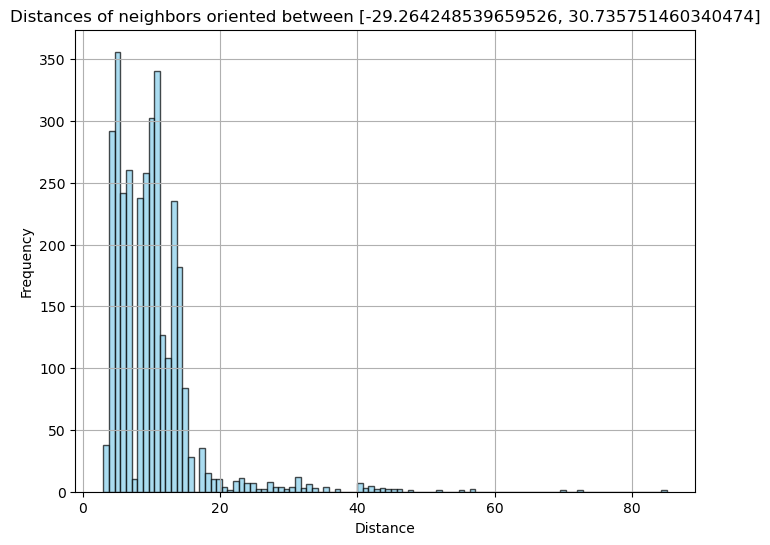

In [166]:
histogram_of_filtered_distances(angles, distances, p, 30)
# todo how can we interpret this ?
# todo instead of using the centroids of the caracters use the min/max x and y, this way we really calculate the distance between the caracters

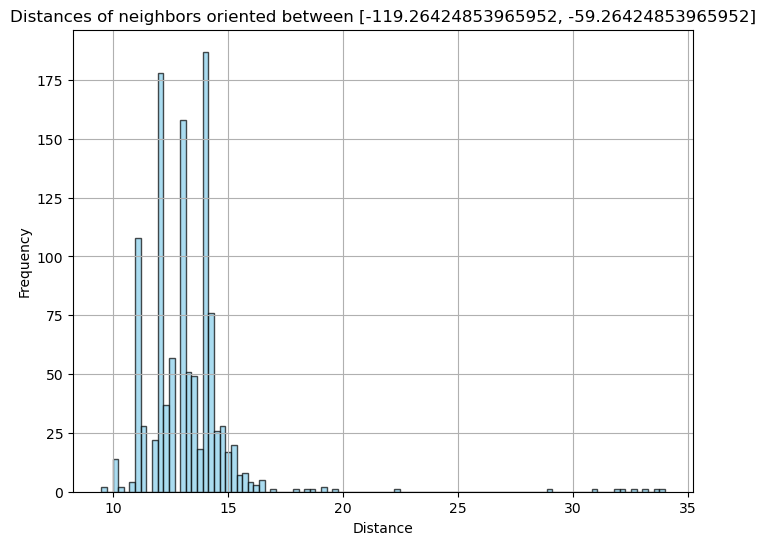

In [167]:
histogram_of_filtered_distances(angles, distances, p-90, 30)

In [168]:
def find_peak_within_angle(neighbor_distances, neighbor_angles, angle, margin):
    """
    Find the peak distance in the neighbor_distances for the neighbors whose angles are within the range [angle - margin, angle + margin]

    Args:
        neighbor_distances (dict): A dictionary where keys are centroid indices, 
                                 and values are lists of distances for the k nearest neighbors.

    Returns:
        float: The peak distance (mode) of the distances distribution.
    """
    # Collect distances for neighbors within the angle range
    filtered_distances = []
    
    for centroid, angles in neighbor_angles.items():
        distances = neighbor_distances[centroid]
        for i, a in enumerate(angles):
            # Check if the angle is within the range [peak - margin, peak + margin]
            if angle - margin <= a <= angle + margin:
                filtered_distances.append(distances[i])

    # Compute the histogram
    hist, bin_edges = np.histogram(filtered_distances, bins=100)
    
    # Find the index of the peak (max frequency)
    peak_index = np.argmax(hist)
    
    # Find the bin center of the peak
    peak_dist = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
    
    return peak_dist

In [169]:
within_line_dist = find_peak_within_angle(distances, angles, p, 30)
print(f'Within-line spacing: {within_line_dist}')
inter_line_dist = find_peak_within_angle(distances, angles, p-90, 30)
print(f'Inter-line spacing: {inter_line_dist}')

Within-line spacing: 5.053673295740801
Inter-line spacing: 14.02448887923882


### Transitive closure

Transitive closure on within-line nearest-neighbor pairings to obtain nearest-neighbor groups on the same text lines.

Again, there's a margin to define the angle range I'm setting by hand.

In [170]:
from collections import defaultdict, deque

def transitive_closure(neighbors, angles, angle_range):
    """
    Find equivalence classes based on the relation defined by neighbors and angles.

    Parameters:
        neighbors (dict): A dictionary where keys are indices and values are lists of nearest neighbors.
        angles (dict): A dictionary where keys are indices and values are lists of angles corresponding to the neighbors.
        angle_range (tuple): A tuple (min_angle, max_angle) specifying the range of valid angles.

    Returns:
        list: A list of equivalence classes, where each class is a set of indices.
    """
    min_angle, max_angle = angle_range

    # Build a graph where edges exist if the angle condition is satisfied
    graph = defaultdict(list)
    for key, neighbor_list in neighbors.items():
        for i, neighbor in enumerate(neighbor_list):
            if min_angle <= angles[key][i] <= max_angle:
                graph[key].append(neighbor)
                graph[neighbor].append(key)  # Ensure bidirectional connection

    # Find connected components (equivalence classes)
    visited = set()
    equivalence_classes = []

    def bfs(start):
        queue = deque([start])
        component = set()
        while queue:
            node = queue.popleft()
            if node not in visited:
                visited.add(node)
                component.add(node)
                queue.extend(graph[node])
        return component

    for node in neighbors:
        if node not in visited:
            equivalence_classes.append(bfs(node))

    return equivalence_classes

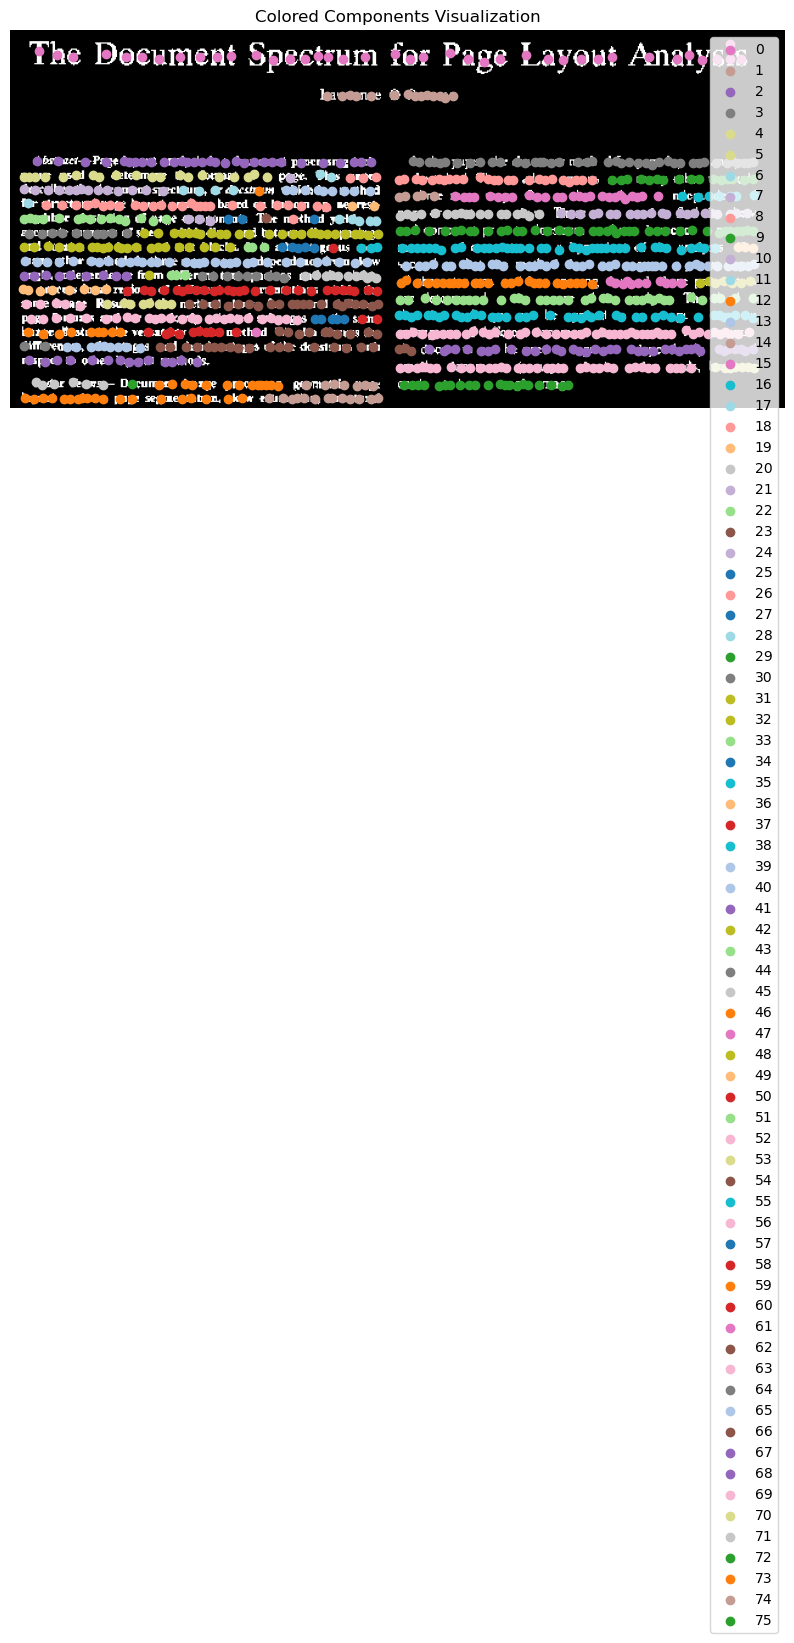

In [171]:
components = transitive_closure(neighbors, angles, (p-30, p+30))

# Visualize components
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')

colors = [plt.cm.tab20(i / (len(components) - 1)) for i in range(len(components))]

# Shuffle the colors to have more contrast in subsequent lines
import random
random.shuffle(colors)

for i in range(len(components)):
    centroids_line = [centroids[k] for k in components[i]]
    x, y = zip(*centroids_line)
    plt.scatter(x, y, color=colors[i], label=f"{i}")

plt.legend()
plt.title("Colored Components Visualization")
plt.axis("off")
plt.show()

### Fit a straight line to the centroids in each component

/tmp/ipykernel_168001/1790421502.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, poly1d_fn(x), '--k', color=colors[i], label=f"{i}")
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x,y,1)
/tmp/ipykernel_168001/1790421502.py:8: RankWarning: Polyfi

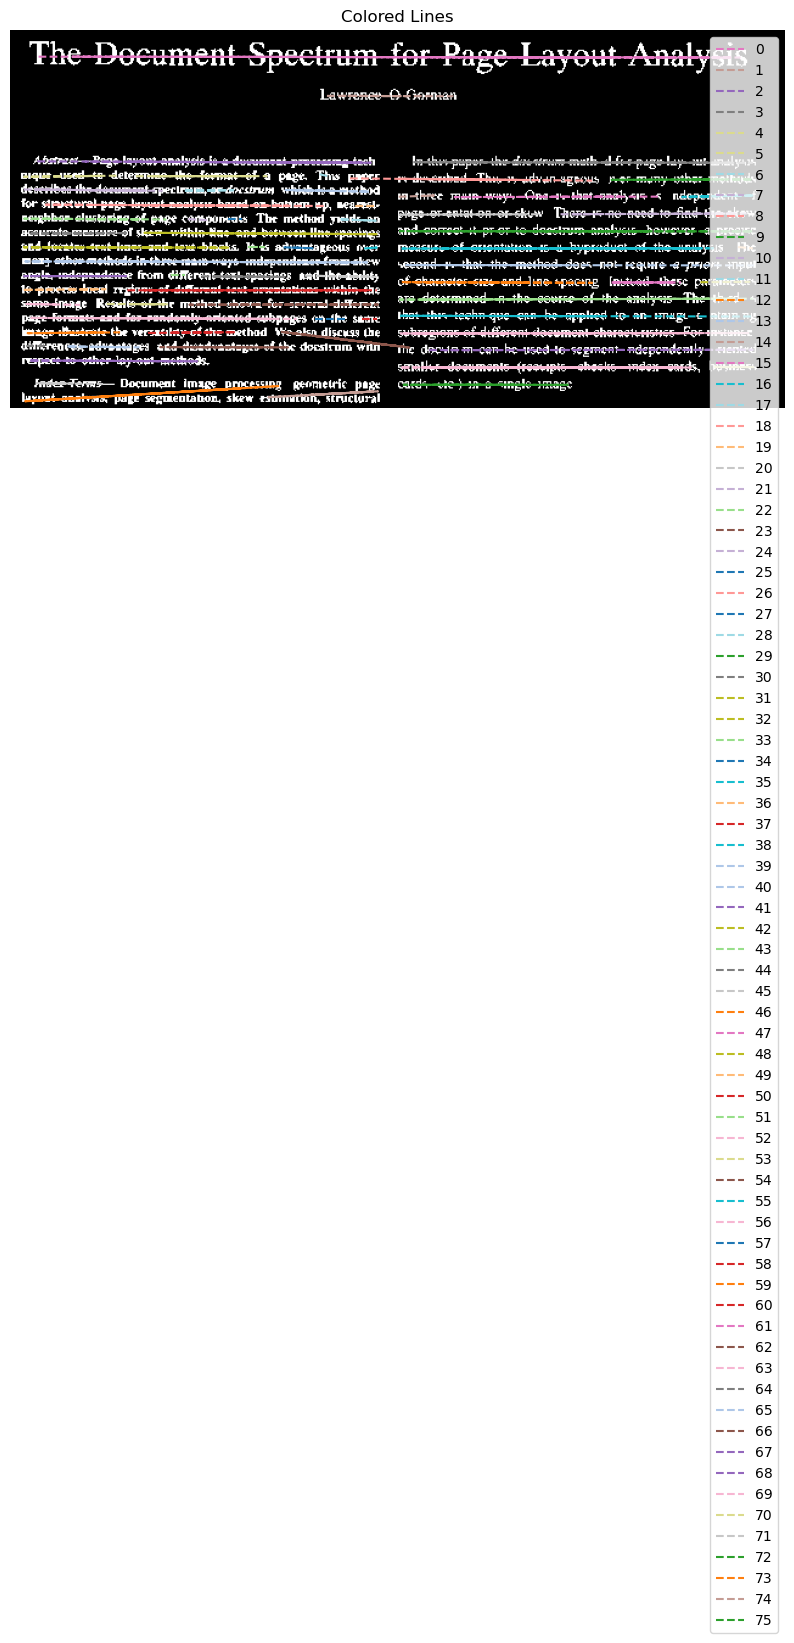

In [172]:
lines = {}

plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
for i in range(len(components)):
    centroids_line = [centroids[k] for k in components[i]]
    x, y = zip(*centroids_line)
    coef = np.polyfit(x,y,1)    
    poly1d_fn = np.poly1d(coef) 
    lines[i] = [(min(x), poly1d_fn(min(x))), (max(x),poly1d_fn(max(x)))] # endpoints of each segment
    plt.plot(x, poly1d_fn(x), '--k', color=colors[i], label=f"{i}") 
plt.legend()
plt.title("Colored Lines")
plt.axis("off")
plt.show()


In [173]:
print(lines[1])
print(lines[2])
print ("number of lines = ", len(lines))

[(260, np.float64(53.55246614531914)), (364, np.float64(53.83805316642866))]
[(22, np.float64(107.38036024354639)), (296, np.float64(108.50850602960647))]
number of lines =  76


### Structural Block Determination

Two text lines are said to belong to the same structural block if they are:

- approximately parallel, 

- close in perpendicular distance, 

- overlaping to some specified degree or separated by only a small distance in parallel distance.

Overlap:

Given segment $i$ and segment $j$, the overlap $p_{ij}$ is an approximation of the length that segment $i$ would overlap onto $j$ if both were parallel and $i$
were translated perpendicularly onto $j$.

Let $\lbrace (x^i_O, y^i_O), (x^i_F, y^i_F) \rbrace$ and $\lbrace (x^j_O, y^j_O), (x^j_F, y^j_F) \rbrace$ be the starting and ending points of segments $i$ and $j$, respectively.

We want to tanslate $(x^i_O, y^i_O)$ onto $(x^j_A, y^j_A)$ and  $(x^i_F, y^i_F)$ onto $(x^j_B, y^j_B)$, as in Fig. 8 in the paper.

To do so, first consider the line generated by segment $i$:

$r_i) \quad (x - x^i_O) \Delta y^i = (y - y^i_O) \Delta x^i$,  where $\Delta x^i = x^i_F - x^i_O$ and $\Delta y^i = y^i_F - y^i_O$

The line $l_i$ perpendicular to $r_i$ and passing by $(x^i_O, y^i_O)$ is given by:

$l_i) \quad - \Delta x^i (x - x^i_O) = \Delta y^i (y - y^i_O)$

Then, to find $(x^j_A, y^j_A)$ we just need to intersect $l_i$ with $r_j$, the line generated by segment $j$.

If $\Delta x^j \neq 0$, this gives Eq. 2 in the paper. 

Else, if $\Delta x^j = 0$, it gives:

$x_A^j = x^j_O$ and $y_A^j = \frac{\Delta x^i (x_O^i - x_A^i)}{\Delta y^i} + y_O^i$ 

Note that, if $\Delta x^j = 0 = \Delta y^i$, segment $i$ and segment $j$ are perpendicular.


"The overlap parameter value is set to zero (no overlap is required in the default mode)"

In [174]:
def segment_length(segment):
    segment = np.array(segment)
    return np.linalg.norm(segment[1] - segment[0])

def get_middle_points(xOj, yOj, xFj, yFj, xAj, yAj, xBj, yBj):
    """
    Get the two middle points from a list of four collinear points.

    Parameters:
        points (list of tuples): A list of four points represented as (x, y).

    Returns:
        list of tuples: The two middle points.
    """
    points = [(xOj, yOj), (xFj, yFj), (xAj, yAj), (xBj, yBj)]
    # Sort points by x-coordinate (and y-coordinate as a tie-breaker if needed)
    sorted_points = sorted(points, key=lambda p: (p[0], p[1]))
    # Return the two middle points
    return sorted_points[1:3]

def overlap_segment(seg_i, seg_j):
    (xOi, yOi) = seg_i[0]
    (xFi, yFi) = seg_i[1]
    (xOj, yOj) = seg_j[0]
    (xFj, yFj) = seg_j[1]
    Δxi = xFi - xOi
    Δxj = xFj - xOj
    Δyi = yFi - yOi
    Δyj = yFj - yOj
    if Δxj != 0:
        xAj = (xOi*Δxi*Δxj+ xOj*Δyi*Δyj+ Δyi*Δxj*(yOi - yOj)) / (Δxi*Δxj+Δyi*Δyj)
        xBj = (xFi*Δxi*Δxj+ xFj*Δyi*Δyj+ Δyi*Δxj*(yFi - yFj)) / (Δxi*Δxj+Δyi*Δyj)
        yAj = (xAj - xOj) * Δyj / Δxj + yOj
        yBj = (xBj - xFj) * Δyj / Δxj + yFj
    else:
        xAj = xOj
        yAj = (- xAj + xOj) * Δxi / Δyi + yOi
        xBj = xOj
        yBj = (- xBj + xFj) * Δxi / Δyi + yFi
    # get middle coordinates
    C, D = get_middle_points(xOj, yOj, xFj, yFj, xAj, yAj, xBj, yBj)
    return C, D

def overlap_parameter(C, D, seg_j):
    pij = segment_length([C,D]) / segment_length(seg_j)
    # check if there is overlap or not
    if max(C,D) <= min(seg_j[0], seg_j[1]): # no overlap 
        pij *= -1 
    if min(C,D) >= max(seg_j[0], seg_j[1]): # no overlap 
        pij *= -1 
    return pij

def parallel_distance(C, D, seg_j): #repeated computations from previous function for the sake of clarity
    Da = segment_length([C,D]) 
    # check if there is overlap or not
    if max(C,D) <= min(seg_j[0], seg_j[1]): # no overlap 
        Da *= -1 
    if min(C,D) >= max(seg_j[0], seg_j[1]): # no overlap 
        Da *= -1 
    return Da

def perpendicular_distance(C, D, seg_i, seg_j):
    (xOi, yOi) = seg_i[0]
    (xFi, yFi) = seg_i[1]
    (xOj, yOj) = seg_j[0]
    (xFj, yFj) = seg_j[1]
    Δxi = xFi - xOi
    Δxj = xFj - xOj
    Δyi = yFi - yOi
    Δyj = yFj - yOj
    (xCj, yCj) = C
    (xDj, yDj) = D
    xMj = (xCj + xDj)/2
    yMj = (yCj + yDj)/2
    if Δxi != 0 and Δyi != 0:
        De = ((xMj - xOi) - Δxi * (yMj - yOi)/ Δyi) / np.sqrt(Δxi**2 / Δyi**2 + 1) 
    elif Δxi == 0:
        De = xMj - xOi
    else:
        De = yMj - yOi
    return De

def angular_diference(seg_i, seg_j):
    (xOi, yOi) = seg_i[0]
    (xFi, yFi) = seg_i[1]
    (xOj, yOj) = seg_j[0]
    (xFj, yFj) = seg_j[1]
    Δxi = xFi - xOi
    Δxj = xFj - xOj
    Δyi = yFi - yOi
    Δyj = yFj - yOj
    θij = np.arctan(Δyj/Δxj) - np.arctan(Δyi/Δxi)
    θij = θij%180
    return θij

def parallelness_critera(seg_i, seg_j, tolerance=30):
    θij = angular_diference(seg_i, seg_j)
    return np.abs(θij) < tolerance

def perpendicular_distance_critera(seg_i, seg_j, max_dist):
    C, D = overlap_segment(seg_i, seg_j)
    De = perpendicular_distance(C, D, seg_i, seg_j)
    return np.abs(De) < max_dist

def parallel_distance_critera(seg_i, seg_j, min_dist):
    C, D = overlap_segment(seg_i, seg_j)
    Da = parallel_distance(C, D, seg_j)
    return Da > min_dist

def overlap_criteria(seg_i, seg_j, threshold = 0):
    C, D = overlap_segment(seg_i, seg_j)
    pij = overlap_parameter(C, D, seg_j)
    return pij > threshold


In [175]:
min(False, False, True)

False

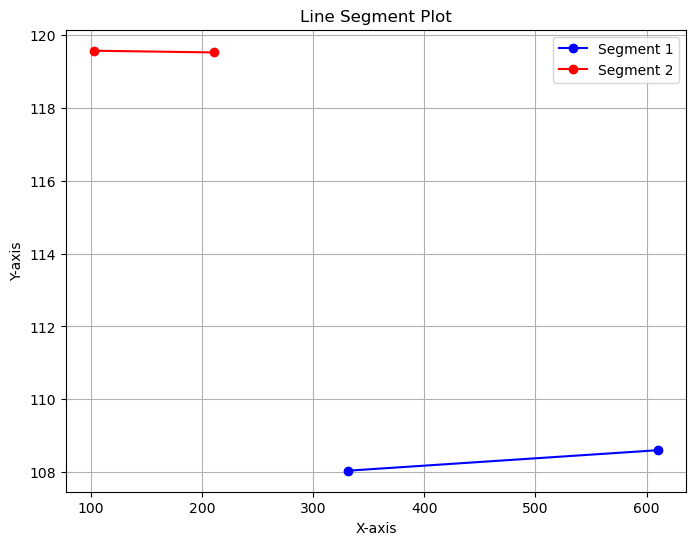

-11.579904903322616


In [176]:
# Function to plot a line segment
def plot_segment(segment, label, color):
    x_values = [segment[0][0], segment[1][0]]
    y_values = [segment[0][1], segment[1][1]]
    plt.plot(x_values, y_values, label=label, color=color, marker='o')

# Plot the segments
plt.figure(figsize=(8, 6))
plot_segment(lines[3], "Segment 1", "blue")
plot_segment(lines[5], "Segment 2", "red")
# Formatting the plot
plt.title("Line Segment Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

C,D = overlap_segment(lines[3], lines[5])
print(perpendicular_distance(C, D, lines[3], lines[5]))

In [177]:
lines

{0: [(23, np.float64(21.335027129264027)),
  (600, np.float64(22.03419494604574))],
 1: [(260, np.float64(53.55246614531914)),
  (364, np.float64(53.83805316642866))],
 2: [(22, np.float64(107.38036024354639)),
  (296, np.float64(108.50850602960647))],
 3: [(331, np.float64(108.03746585104008)),
  (610, np.float64(108.60037787531552))],
 4: [(11, np.float64(120.08006962576155)),
  (87, np.float64(119.13751087902529))],
 5: [(103, np.float64(119.5697884205347)),
  (211, np.float64(119.5225520747909))],
 6: [(254, np.float64(118.00000000000006)),
  (263, np.float64(120.00000000000003))],
 7: [(230, np.float64(120.99999999999999)),
  (230, np.float64(120.99999999999999))],
 8: [(279, np.float64(121.37333827984911)),
  (478, np.float64(123.2067025289062))],
 9: [(494, np.float64(122.57296779040227)),
  (610, np.float64(122.18167043258897))],
 10: [(11, np.float64(130.4840294133166)),
  (125, np.float64(131.58642440173253))],
 11: [(142, np.float64(131.40118790496768)),
  (183, np.float64(1

In [178]:
def should_group(seg_i, seg_j, θ_tolerance, max_De, min_Da, min_overlap):
    crit1 = parallelness_critera(seg_i, seg_j, θ_tolerance)
    crit2 = perpendicular_distance_critera(seg_i, seg_j, max_De)
    crit3 = parallel_distance_critera(seg_i, seg_j, min_Da)
    crit4 = overlap_criteria(seg_i, seg_j, min_overlap)
    return min(crit1, crit2, crit3, crit4)
    
def assign_blocks(lines):
    """
    Groups lines into blocks based on the should_group criteria.

    Parameters:
    lines (list): A list of lines to be grouped.

    Returns:
    dict: A dictionary where keys are block labels and values are lists of lines in each block.
    """
    blocks = {}  # Dictionary to hold block labels and their lines
    line_to_block = {}  # Maps each line to its block label

    def find_block(line):
        """Helper function to find the block label of a line."""
        return line_to_block.get(tuple(line))  # Ensure the line is hashable

    def merge_blocks(block1, block2):
        """Helper function to merge two blocks."""
        if block1 == block2:
            return
        # Merge block2 into block1
        for line in blocks[block2]:
            line_to_block[tuple(line)] = block1
        blocks[block1].extend(blocks[block2])
        del blocks[block2]

    # Iterate through all pairs of lines
    for i in range(len(lines)):
        line1 = lines[i]
        for j in range(len(lines)):
            line2 = lines[j]
            if should_group(line1, line2, 30, 1.3*18, 9*1.5, 0):
                block1 = find_block(tuple(line1))
                block2 = find_block(tuple(line2))

                if block1 is None and block2 is None:
                    # Both lines are unassigned; create a new block
                    new_block_label = len(blocks) + 1
                    blocks[new_block_label] = [line1, line2]
                    line_to_block[tuple(line1)] = new_block_label
                    line_to_block[tuple(line2)] = new_block_label

                elif block1 is not None and block2 is None:
                    # line1 is in a block, assign line2 to the same block
                    if block1 in blocks: # Ensure block1 exists
                        blocks[block1].append(line2)
                        line_to_block[tuple(line2)] = block1

                elif block1 is None and block2 is not None:
                    # line2 is in a block, assign line1 to the same block
                    if block2 in blocks:  # Ensure block2 exists
                        blocks[block2].append(line1)
                        line_to_block[tuple(line1)] = block2

                elif block1 != block2:
                    # Both lines are in different blocks; merge them
                    merge_blocks(block1, block2)

    return blocks

In [179]:
blocks = assign_blocks(lines)

/tmp/ipykernel_168001/2108513895.py:92: RuntimeWarning: invalid value encountered in scalar divide
  θij = np.arctan(Δyj/Δxj) - np.arctan(Δyi/Δxi)
/tmp/ipykernel_168001/2108513895.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  pij = segment_length([C,D]) / segment_length(seg_j)
/tmp/ipykernel_168001/2108513895.py:31: RuntimeWarning: invalid value encountered in scalar divide
  xAj = (xOi*Δxi*Δxj+ xOj*Δyi*Δyj+ Δyi*Δxj*(yOi - yOj)) / (Δxi*Δxj+Δyi*Δyj)
/tmp/ipykernel_168001/2108513895.py:32: RuntimeWarning: invalid value encountered in scalar divide
  xBj = (xFi*Δxi*Δxj+ xFj*Δyi*Δyj+ Δyi*Δxj*(yFi - yFj)) / (Δxi*Δxj+Δyi*Δyj)
/tmp/ipykernel_168001/2108513895.py:37: RuntimeWarning: invalid value encountered in scalar divide
  yAj = (- xAj + xOj) * Δxi / Δyi + yOi
/tmp/ipykernel_168001/2108513895.py:39: RuntimeWarning: invalid value encountered in scalar divide
  yBj = (- xBj + xFj) * Δxi / Δyi + yFi
/tmp/ipykernel_168001/2108513895.py:45: RuntimeWarning: invalid value e

In [180]:
blocks

{1: [[(23, np.float64(21.335027129264027)),
   (600, np.float64(22.03419494604574))],
  [(23, np.float64(21.335027129264027)),
   (600, np.float64(22.03419494604574))]],
 2: [[(260, np.float64(53.55246614531914)),
   (364, np.float64(53.83805316642866))],
  [(260, np.float64(53.55246614531914)),
   (364, np.float64(53.83805316642866))]],
 4: [[(212, np.float64(301.2127578420603)),
   (302, np.float64(296.37524411082626))],
  [(212, np.float64(301.2127578420603)),
   (302, np.float64(296.37524411082626))],
  [(323, np.float64(291.03196279497786)),
   (458, np.float64(291.0635763820416))]]}

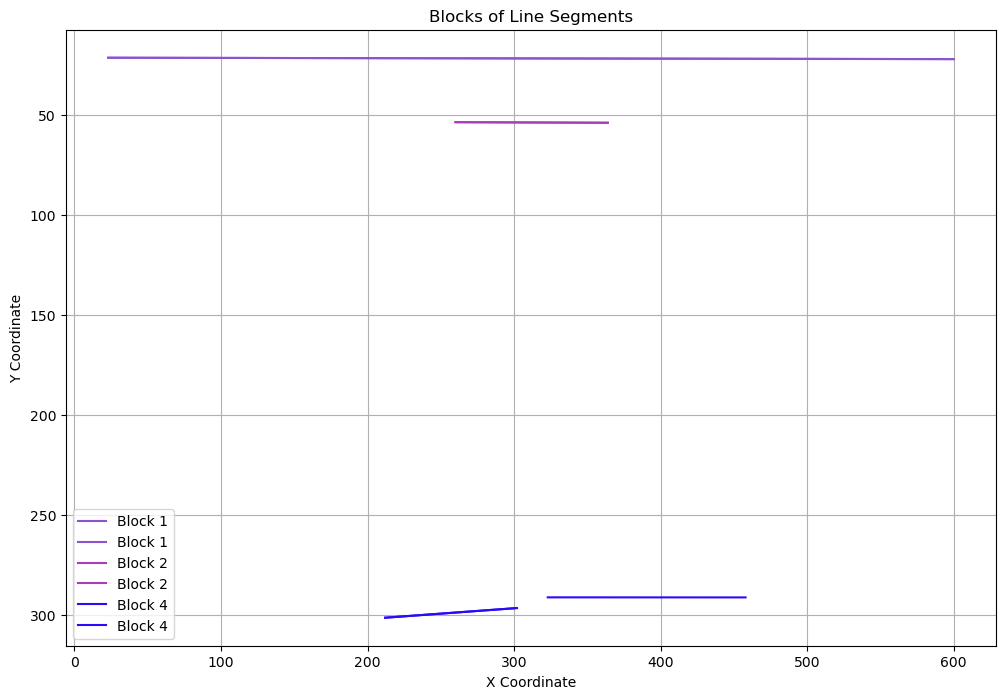

In [181]:
def plot_blocks(blocks):
    """
    Plots blocks of line segments in different colors.

    Parameters:
    blocks (dict): A dictionary where keys are block labels and values are lists of line segments.
                   Each line segment is represented as [(x1, y1), (x2, y2)].
    """
    # Generate unique colors for each block
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(len(blocks))]

    

    plt.figure(figsize=(12, 8))
    for idx, (block_label, line_segments) in enumerate(blocks.items()):
        block_color = colors[idx]  # Assign color dynamically based on index
        for segment in line_segments:
            # Extract start and end points
            (x1, y1), (x2, y2) = segment
            # Plot the line segment
            plt.plot([x1, x2], [y1, y2], color=block_color, label=f"Block {block_label}" if segment == line_segments[0] else "")

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Blocks of Line Segments")
    plt.legend()
    plt.grid(True)
    # invert the plot to have the same orientation as the image
    plt.gca().invert_yaxis()
    plt.show()

plot_blocks(blocks)